# Boosting

Training D1_D2 dataset using the `Boosting` ensemble method.

### Author
Anna Gansen

In [4]:
# import libraries
import warnings
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# import sklearn model training
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

#metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

# import visualization library
from matplotlib import pyplot as plt
# import libraries
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# base learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ensemble learning - stacking
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer, confusion_matrix

# import visualization library
from matplotlib import pyplot as plt
import seaborn as sns


# set seed (for reproducibility)
np.random.seed(43)

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

### Data Loading + Preprocessing

In [5]:
# initialize class
tp = Tadpole(debug=True)

loading tadpole dataset
pre-processing dataset


In [6]:
# load and pre-process tadpole dataset
tp.load()
print(tp.label_dict)

loading tadpole dataset
pre-processing dataset
{0: 'AD', 1: 'CN', 2: 'MCI'}


##### Split data into Train and Test datasets

In [7]:
# train-test split
tp.split()

splitting dataset to train and test datasets


(array([[0.        , 0.12491212, 0.91666667, ..., 0.20507751, 1.        ,
         0.41621622],
        [0.25      , 0.44527771, 0.5       , ..., 0.27756092, 0.5       ,
         0.57837838],
        [0.        , 0.10147645, 1.        , ..., 0.04599641, 0.        ,
         0.59189189],
        ...,
        [0.        , 0.14834779, 1.        , ..., 0.20507751, 0.        ,
         0.5       ],
        [0.3       , 0.32809937, 0.5       , ..., 0.54879207, 1.        ,
         0.11081081],
        [0.        , 0.10147645, 1.        , ..., 0.20507751, 0.        ,
         0.6       ]]),
 array([[0.1       , 0.20318725, 1.        , ..., 0.20507751, 0.5       ,
         0.43783784],
        [0.05      , 0.18748535, 1.        , ..., 0.01983332, 0.        ,
         0.19459459],
        [0.15      , 0.19521912, 1.        , ..., 0.20507751, 0.5       ,
         0.37837838],
        ...,
        [0.6       , 0.62502929, 0.16666667, ..., 0.33801034, 0.5       ,
         0.20540541],
        [0.2

In [8]:
# import variables from class instance (notebook compatibility)
label_dict = tp.label_dict
X, y, X_train, X_test, y_train, y_test = tp.X, tp.y, tp.X_train, tp.X_test, tp.y_train, tp.y_test

In [9]:
# define scoring parameter
scoring = {'BA': make_scorer(balanced_accuracy_score)}

### Helper Functions

In [10]:
# Source: https://stackoverflow.com/questions/55632010/using-scikit-learns-mlpclassifier-in-adaboostclassifier
class CustomMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

In [ ]:
# def boosting_clf(clf):
#     if (isinstance(clf,SVC)):
#         return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, 
#                                   algorithm = 'SAMME', learning_rate = 0.1)
#     else:
#         return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, learning_rate = 0.1)

In [ ]:
# def accuracy(clf, X, y):
#     y_pred = clf.predict(X)
#     y_prob = clf.predict_proba(X)
#     BCA = balanced_accuracy_score(y, y_pred)
#     print('Balanced accuracy score: ', BCA)
#     mAUC = roc_auc_score(y, y_prob, multi_class="ovo", average="macro")
#     print('Overall mAUC: ', mAUC)

In [ ]:
# def showConfusionMatrix(clf, X, y):
#     cm = confusion_matrix(y, clf.predict(X))
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.imshow(cm, cmap='GnBu')
#     ax.grid(False)

#     # For 3 categories
#     ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
#                                               'Predicted ' + label_dict[2]))
#     ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
#                                               'Actual ' + label_dict[2]))

#     for i in range(3):
#         for j in range(3):
#             ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
#     plt.title('Test Data Confusion Matrix')
#     plt.show()

In [ ]:
# def report_accuracy(clf):
#     print('Train metrics:')
#     accuracy(clf, X_train, y_train)
#     print('\n\nTest metrics:')
#     accuracy(clf, X_test, y_test)
#     showConfusionMatrix(clf, X_test, y_test)

In [ ]:
# def evaluate(Classifier, **kwargs):
#     print('+ Base learner')
#     clf = Classifier(**kwargs).fit(X_train, y_train)
#     report_accuracy(clf)
#     print('+ Ensemble')
#     boost_clf = boosting_clf(Classifier(**kwargs)).fit(X_train, y_train)
#     report_accuracy(boost_clf)

In [11]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='GnBu')
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Test Data Confusion Matrix')
    plt.show()
    
def computeMetrics(model, X, y):
    """
    @description:
        function to compute performance metrics
    @arguments:
        model (sklearn) - trained model
        X (np.array) - features
        y (np.array) - target
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovr", average="macro")
    return BCA, mAUC

def report(model):
    """
    @description:
        function to report trained model performance
    @arguments:
        model (sklearn) - trained model
    """
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    BCA_train, mAUC_train = computeMetrics(model, X_train, y_train)
    BCA_test, mAUC_test = computeMetrics(model, X_test, y_test)
    print("========Model Evaluation Report========")
    print("Train Score: ", score_train)
    print("Test Score: ", score_test)
    print("=======================================")
    print("Train BCA: {:.3f} | Train AUC: {:.3f}".format(BCA_train, mAUC_train))
    print("Test BCA: {:.3f} | Test AUC: {:.3f}".format(BCA_test, mAUC_test))
    print("=======================================")
    showConfusionMatrix(model, X_test, y_test)
    return [score_train, score_test, BCA_train, BCA_test, mAUC_train, mAUC_test]

def evaluate(baselearners):
    """
    @description:
        function to evaluate base learners
    @arguments:
        baselearners (sklearn) - list of trained models
    """
    metrics = []
    for name, model in baselearners.items():
        print(name)
        results = report(model)
        metrics.append([name] + results)
    return metrics

In [ ]:
# def main():
#     baselearners = [DecisionTreeClassifier, 
#                     SVC, 
#                     CustomMLPClassifier,
#                     LogisticRegression]
    
#     for learner in baselearners:
#         print(learner)
#         evaluate(learner)
#         print()

### Model Training
The following parameter grids were found to work best for the base learners: 
    
1. **LRA**: {'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}

2. **DT**: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 'splitter': 'best'}

3. **MLP**: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 
'adam'}

4. **SVM**: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear', 'tol': 1}

### Decision Tree
#### Base Learner

========Model Evaluation Report========
Train Score:  0.7030346820809249
Test Score:  0.7254335260115607
Train BCA: 0.777 | Train AUC: 0.854
Test BCA: 0.788 | Test AUC: 0.868


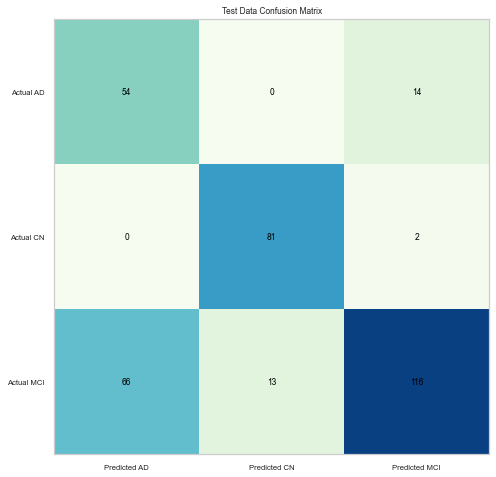

[0.7030346820809249,
 0.7254335260115607,
 0.7769971287866397,
 0.7882976854628166,
 0.8543627222905231,
 0.8684033809191812]

In [27]:
dtc = DecisionTreeClassifier()
dtc.set_params(**{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 
                  'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 
                  'splitter': 'best'})
dtc.fit(X_train, y_train)
report(dtc)

#### Grid Search AdaBoost - Decision Trees

performing grid search
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.7min finished


========Model Evaluation Report========
Train Score:  0.868168829162805
Test Score:  0.8967753366406804
Train BCA: 0.868 | Train AUC: 0.944
Test BCA: 0.897 | Test AUC: 0.955


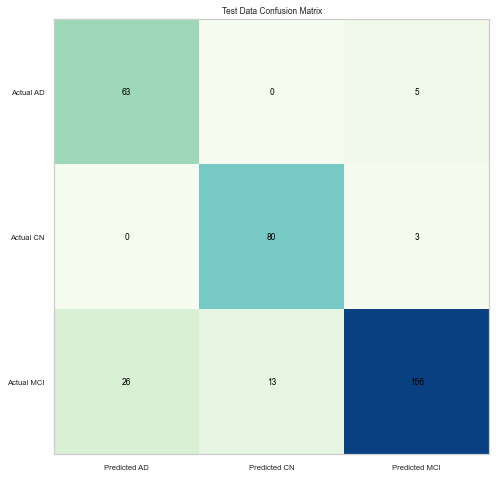

AdaBoost with DT: {'learning_rate': 0.0001, 'n_estimators': 400}


In [28]:
adaboost_param_grid = {'n_estimators'  : [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
                       'learning_rate' : [0.1, 0.01, 0.001, 0.0001, 0.00001, 1]}

dt = DecisionTreeClassifier()
dt.set_params(**{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 
                  'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 
                  'splitter': 'best'})
boosting_clf = AdaBoostClassifier(base_estimator = dt, random_state = 0)
boost_dtc_cv = tp.gridsearch(adaboost_param_grid, boosting_clf, scoring)
metrics = report(boost_dtc_cv)
print("AdaBoost with DT:", boost_dtc_cv.best_params_)

### Logistic Regression Analysis (LRA)
#### Base Learner

[LibLinear]========Model Evaluation Report========
Train Score:  0.875
Test Score:  0.9017341040462428
Train BCA: 0.891 | Train AUC: 0.961
Test BCA: 0.918 | Test AUC: 0.968


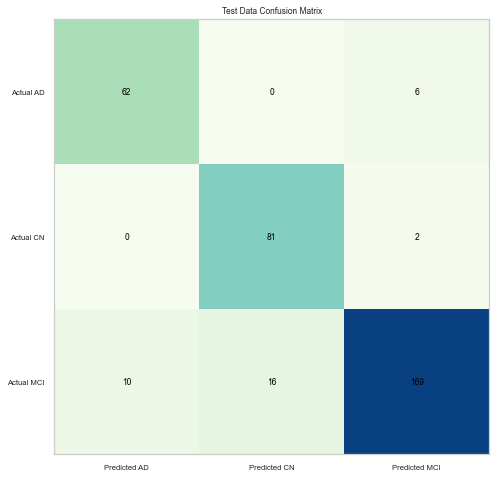

[0.875,
 0.9017341040462428,
 0.8908123444002253,
 0.918111662335617,
 0.9612448482208306,
 0.9684053949935209]

In [47]:
lra = LogisticRegression(verbose=2)
lra.set_params(**{'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 
                'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001})
lra.fit(X_train, y_train)
report(lra)

#### Grid Search AdaBoost - LRA

performing grid search
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.2min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]========Model Evaluation Report========
Train Score:  0.3333333333333333
Test Score:  0.3333333333333333
Train BCA: 0.333 | Train AUC: 0.500
Test BCA: 0.333 | Test AUC: 0.500


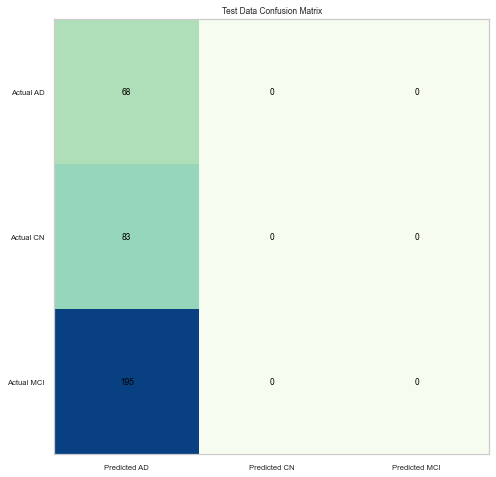

AdaBoost with LRA: {'learning_rate': 0.1, 'n_estimators': 50}


In [14]:
adaboost_param_grid = {'n_estimators'  : [1,2,3],#50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
                       'learning_rate' : [0.1, 0.01, 0.001, 0.0001, 0.00001, 1]}

lra = LogisticRegression(verbose=2)
lra.set_params(**{'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 
                'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001})
boosting_clf = AdaBoostClassifier(base_estimator = lra, random_state = 0)
boost_lra_cv = tp.gridsearch(adaboost_param_grid, boosting_clf, scoring)
metrics = report(boost_lra_cv)
print("AdaBoost with LRA:", boost_lra_cv.best_params_)

### Artifical Neural Network (ANN) - MLP
#### Base Learner

In [50]:
mlp = CustomMLPClassifier(verbose=True)
mlp.set_params(**{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 
                  'learning_rate': 'adaptive', 'solver': 'adam'})
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.21861028
Iteration 2, loss = 1.07606071
Iteration 3, loss = 1.00350976
Iteration 4, loss = 0.97521532
Iteration 5, loss = 0.95249838
Iteration 6, loss = 0.91793541
Iteration 7, loss = 0.88016485
Iteration 8, loss = 0.83073029
Iteration 9, loss = 0.77557749
Iteration 10, loss = 0.71908628
Iteration 11, loss = 0.66799216
Iteration 12, loss = 0.62201038
Iteration 13, loss = 0.58632143
Iteration 14, loss = 0.55981272
Iteration 15, loss = 0.53745443
Iteration 16, loss = 0.52311517
Iteration 17, loss = 0.50560201
Iteration 18, loss = 0.48954673
Iteration 19, loss = 0.47698904
Iteration 20, loss = 0.46274404
Iteration 21, loss = 0.45258717
Iteration 22, loss = 0.44080709
Iteration 23, loss = 0.43095785
Iteration 24, loss = 0.42181579
Iteration 25, loss = 0.41466261
Iteration 26, loss = 0.41027645
Iteration 27, loss = 0.41073551
Iteration 28, loss = 0.39724676
Iteration 29, loss = 0.38811634
Iteration 30, loss = 0.38449000
Iteration 31, loss = 0.37711075
Iteration 32, los

CustomMLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 50, 50),
                    learning_rate='adaptive', verbose=True)

========Model Evaluation Report========
Train Score:  0.8735549132947977
Test Score:  0.9046242774566474
Train BCA: 0.864 | Train AUC: 0.972
Test BCA: 0.895 | Test AUC: 0.973


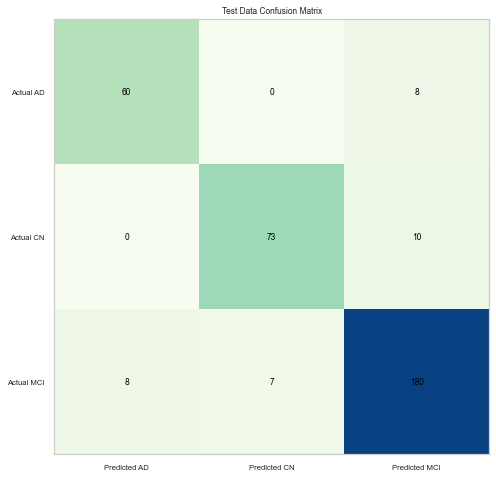

[0.8735549132947977,
 0.9046242774566474,
 0.863965893740876,
 0.8949826455141835,
 0.9721783258837281,
 0.9731615998490688]

In [51]:
report(mlp)

#### Grid Search AdaBoost - MLP

In [ ]:
adaboost_param_grid = {'n_estimators'  : [300, 400],
                       'learning_rate' : [ 0.01, 0.0001]}

mlp = CustomMLPClassifier()
mlp.set_params(**{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 
                  'learning_rate': 'adaptive', 'solver': 'adam'})
boosting_clf = AdaBoostClassifier(base_estimator = mlp, random_state = 0, n_estimators = 300, learning_rate = 0.01)
#boost_mlp_cv = tp.gridsearch(adaboost_param_grid, boosting_clf, scoring,n_jobs=16)
boosting_clf.fit(X_train, y_train)
metrics = report(boosting_clf)
#print("AdaBoost with MLP:", boost_mlp_cv.best_params_)

### SVM
#### Base Learner

[LibSVM]========Model Evaluation Report========
Train Score:  0.8764450867052023
Test Score:  0.8988439306358381
Train BCA: 0.897 | Train AUC: 0.960
Test BCA: 0.916 | Test AUC: 0.970


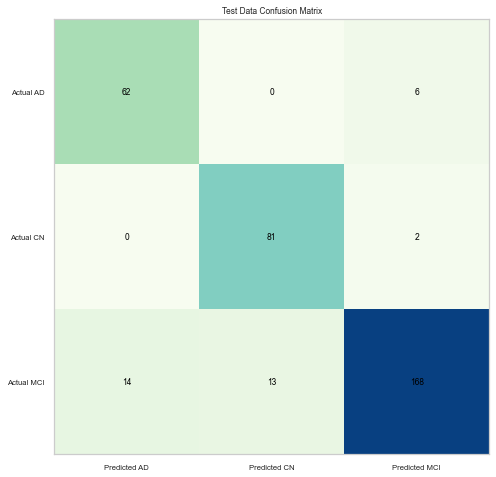

[0.8764450867052023,
 0.8988439306358381,
 0.8971203062627584,
 0.9164022606262153,
 0.9601890434951211,
 0.9700113119464792]

In [10]:
svm = SVC(verbose=True, probability=True)
svm.set_params(**{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 
                  'kernel': 'linear', 'tol': 1})
svm.fit(X_train, y_train)
report(svm)

#### Grid Search AdaBoost - SVM

performing grid search
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 30.0min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 65.8min finished


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

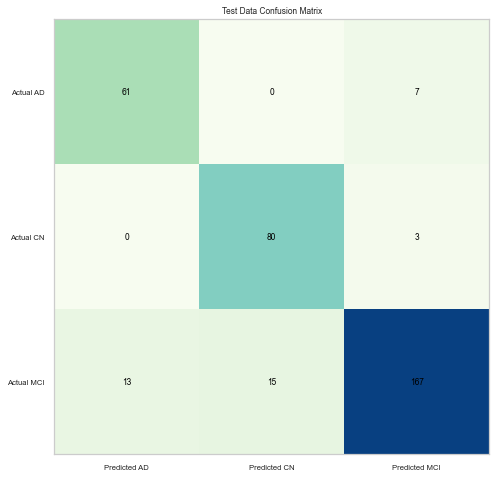

AdaBoost with SVM: {'learning_rate': 0.01, 'n_estimators': 300}


In [11]:
adaboost_param_grid = {'n_estimators'  : [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
                       'learning_rate' : [0.1, 0.01, 0.001, 0.0001, 0.00001, 1]}

svm = SVC(verbose=True, probability=True)
svm.set_params(**{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 
                  'kernel': 'linear', 'tol': 1})
boosting_clf = AdaBoostClassifier(base_estimator = svm, random_state = 0, algorithm = 'SAMME')
boost_svm_cv = tp.gridsearch(adaboost_param_grid, boosting_clf, scoring)
metrics = report(boost_svm_cv)
print("AdaBoost with SVM:", boost_svm_cv.best_params_)

### Results of Grid Search for AdaBoost and the different Base Learners:
* AdaBoost with SVM: {'learning_rate': 0.01, 'n_estimators': 300}
* AdaBoost with DT: {'learning_rate': 0.0001, 'n_estimators': 400}
* AdaBoost with LRA: {'learning_rate': 0.1, 'n_estimators': 50}
* MLP missing

### Comparison of Base Learners and Ensemble Methods

#### Decision Tree
* **Base Learner:** 
    - BCA: 0.688 (Train), 0.698 (Test)
    - mAUC: 0.768 (Train), 0.775 (Test)
    - Accuracy: 0.5447976878612717 (Train), 0.569364161849711 (Test)
* **AdaBoost:** 
    - BCA: 0.868 (Train), 0.897 (Test)
    - mAUC: 0.944 (Train), 0.955 (Test)
    - Accuracy: 0.868168829162805 (Train), 0.8967753366406804 (Test)
    
#### LRA
* **Base Learner:** 
    - BCA: 0.688 (Train), 0.698 (Test)
    - mAUC: 0.768 (Train), 0.775 (Test)
    - Accuracy: 0.5447976878612717 (Train), 0.569364161849711 (Test)
* **AdaBoost:** 
    - BCA: 0.868 (Train), 0.897 (Test)
    - mAUC: 0.944 (Train), 0.955 (Test)
    - Accuracy: 0.868168829162805 (Train), 0.8967753366406804 (Test)

#### MLP
* Base Learner:
* AdaBoost: 

#### SVM
* Base Learner:
* AdaBoost: 


Decision Tree
========Model Evaluation Report========
Train Score:  0.8562138728323699
Test Score:  0.884393063583815
Train BCA: 0.885 | Train AUC: 0.967
Test BCA: 0.906 | Test AUC: 0.970


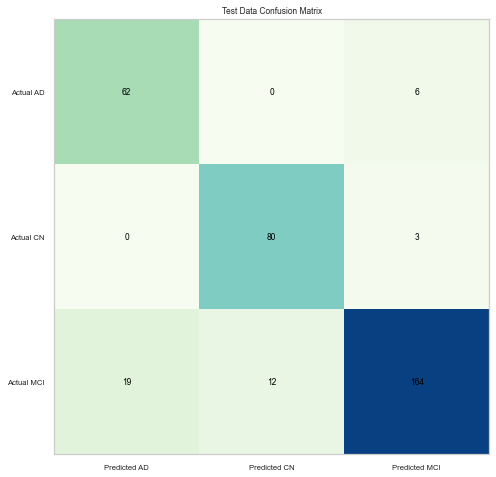

SVC
========Model Evaluation Report========
Train Score:  0.8547687861271677
Test Score:  0.8815028901734104
Train BCA: 0.859 | Train AUC: 0.953
Test BCA: 0.874 | Test AUC: 0.966


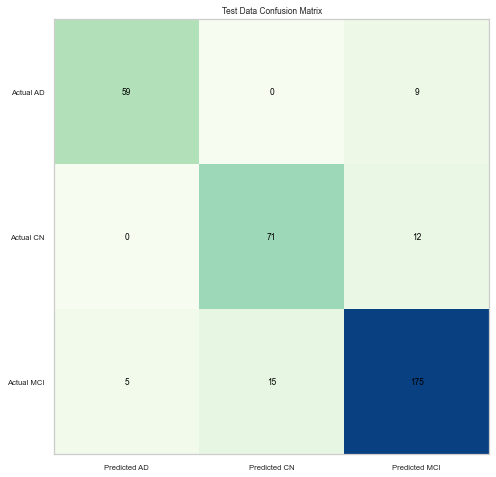

MLP
========Model Evaluation Report========
Train Score:  0.8937861271676301
Test Score:  0.9132947976878613
Train BCA: 0.896 | Train AUC: 0.978
Test BCA: 0.917 | Test AUC: 0.974


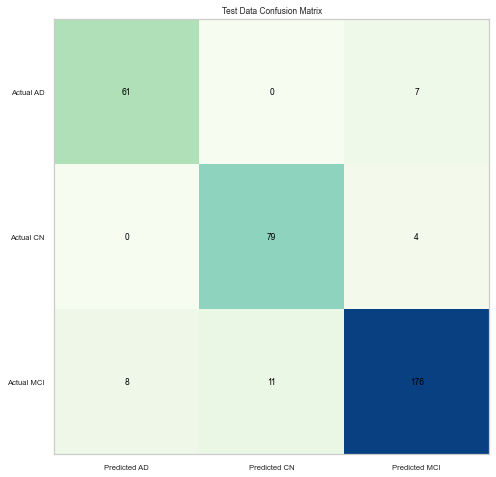

LRA
========Model Evaluation Report========
Train Score:  0.19653179190751446
Test Score:  0.19653179190751446
Train BCA: 0.333 | Train AUC: 0.500
Test BCA: 0.333 | Test AUC: 0.500


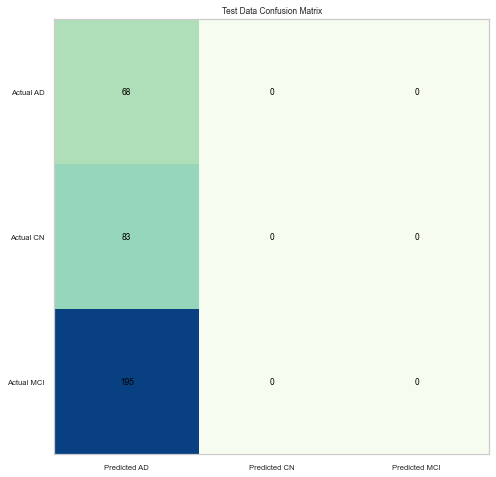

In [31]:
# custom modules
from tadpole import Tadpole
from classifier import Classifier
from main import run, get_params

# parameters
params_dtc = get_params('dtc')
params_svc = get_params('svc')
params_lra = get_params('lra')
params_ann = get_params('ann')

params_boost_dtc = {'learning_rate': 0.0001, 'n_estimators': 400}
params_boost_svc = {'learning_rate': 0.01, 'n_estimators': 300}
params_boost_lra = {'learning_rate': 0.1, 'n_estimators': 50}
params_boost_ann = {'learning_rate': 0.0001, 'n_estimators': 300}

# Decision Tree
print("Decision Tree")
dtc = DecisionTreeClassifier()
dtc.set_params(**params_dtc)

boost_clf = AdaBoostClassifier(base_estimator = dtc,                             
                            random_state = 0,
                            **params_boost_dtc)
boost_clf.fit(X_train, y_train)
metrics_boost_dtc = report(boost_clf)

# SVC
print("SVC")
svc = SVC(probability=True)
svc.set_params(**params_svc)

boost_clf = AdaBoostClassifier(base_estimator = svc,                             
                            random_state = 0,
                            **params_boost_svc)
boost_clf.fit(X_train, y_train)
metrics_boost_svc = report(boost_clf)

# MLP
print("MLP")
ann = CustomMLPClassifier()
ann.set_params(**params_ann)

boost_clf = AdaBoostClassifier(base_estimator = ann,                              
                            random_state = 0,
                            **params_boost_ann)
boost_clf.fit(X_train, y_train)
metrics_boost_mlp = report(boost_clf)

# LRA
print("LRA")
lra = LogisticRegression()
lra.set_params(**params_lra)

boost_clf = AdaBoostClassifier(base_estimator = lra,                             
                            random_state = 0,
                            **params_boost_lra)
boost_clf.fit(X_train, y_train)
metrics_boost_lra = report(boost_clf)

In [27]:
# add stacking results
metrics = []
metrics.append(['DTC'] + metrics_boost_dtc)
metrics.append(['SVC'] + metrics_boost_svc)
metrics.append(['LRA'] + metrics_boost_lra)
metrics.append(['MLP'] + metrics_boost_mlp)
# create results dataframe
results_df = pd.DataFrame(metrics, columns=['classifier', 'score_train', 'score_test', 'BCA_train', 'BCA_test', 'mAUC_train', 'mAUC_test'])

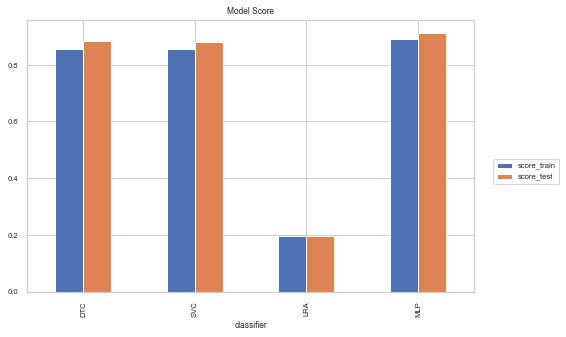

In [28]:
results_df.plot(x='classifier', y=['score_train', 'score_test'], kind='bar', 
                title='Model Score', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

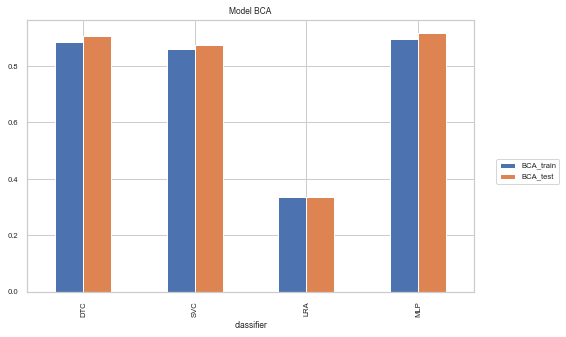

In [29]:
results_df.plot(x='classifier', y=['BCA_train', 'BCA_test'], kind='bar', 
                title='Model BCA', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

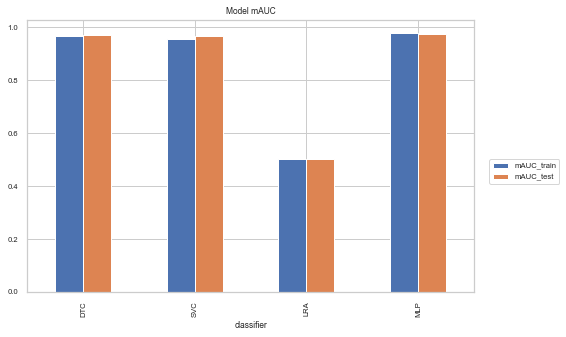

In [30]:
results_df.plot(x='classifier', y=['mAUC_train', 'mAUC_test'], kind='bar', 
                title='Model mAUC', grid=True).legend(bbox_to_anchor=(1.2, 0.5));